In [108]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# 归因模型：线性归因 ModelAttribution_Linear

# 超参数
SIGN_LINER = 0.7 #判断是否线性相关的显著性
SIGN_PVALUE = 0.05 #判断pValue的显著性

# 读取excel文件并获取指定列
df = pd.read_csv('Data\store_6922.csv', usecols=['dt', 'amt', 'discount_amount', 'pay_amount', 'num', 'discount', 'discount_percent', 'workdays', 'holidays', 'weekdays', 'text_day', 'text_night', 'high', 'low', 'high_low', 'wc_day'], encoding='GBK')
#print(df)

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\admin\AppData\Local\Temp\ipykernel_26348\545906134.py:12: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('Data\store_6922.csv', usecols=['dt', 'amt', 'discount_amount', 'pay_amount', 'num', 'discount', 'discount_percent', 'workdays', 'holidays', 'weekdays', 'text_day', 'text_night', 'high', 'low', 'high_low'], encoding='GBK')


In [109]:
# 等待用户输入一个索引值和列名，在df中取出对应值。
value_index = input("待归因值的Index：")
value_column = input("待归因值的列名：")
value_cell = df.loc[int(value_index),value_column]
print("待归因的值为第[%s]行的‘%s’值为：%s"% (value_index, value_column, value_cell))

# 等待用户输入一个假设与待归因值有 线性关系 的 列名
value_column_liner = input("待分析的列名：")
print("正在分析...造成第[%s]行的‘%s’值为：%s 的原因，是否与[%s]相关"% (value_index, value_column, value_cell, value_column_liner))

待归因的值为第[13]行的‘high_low’值为：10
正在分析...造成第[13]行的‘high_low’值为：10 的原因，是否与[amt]相关


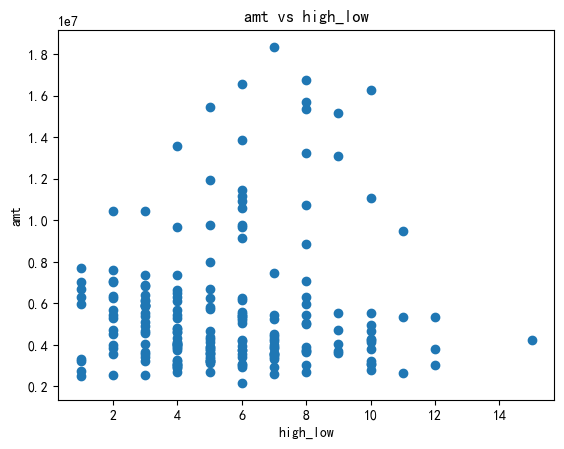

In [110]:
#画出散点图
import matplotlib.pyplot as plt

# 设置字体，确保能正确显示汉字
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体

# 绘制散点图
plt.scatter(df[value_column], df[value_column_liner])

# 添加标题和坐标轴标签
plt.title(value_column_liner+' vs '+value_column)
plt.xlabel(value_column)
plt.ylabel(value_column_liner)

# 显示图形
plt.show()


In [111]:
# 计算相关系数
corr = df[value_column].corr(df[value_column_liner])

# 判断线性关系强度
if corr > SIGN_LINER:
    print("具有强正向线性关系, 显著性为", corr)
elif corr < -SIGN_LINER:
    print("具有强负向线性关系, 显著性为", corr)
else:
    print("线性关系强度不足, 显著性为", corr)

线性关系强度不足, 显著性为 0.08754056088710575


In [112]:
# 拟合出 两者相关性的线性 函数

# 在拟合前，把待归因单元格的相关数据取出来，之后从df表中剔除掉待分析行的数据
target_x = df.loc[int(value_index),value_column]
target_y = df.loc[int(value_index),value_column_liner]
df = df.drop(int(value_index), axis=0)
print("target_x:", target_x)
print("target_y:", target_y)

# 使用最小二乘法拟合数据
column_x = df[value_column]
column_y = df[value_column_liner]
coefficients = np.polyfit(column_x, column_y, 1)

# 提取斜率和截距
slope = coefficients[0]
intercept = coefficients[1]

# 打印拟合出的线性函数的参数
print("斜率:", slope)
print("截距:", intercept)

target_x: 10
target_y: 3797090.69
斜率: 112431.39404768847
截距: 5034364.11200058


In [113]:
# 通过函数 预测一遍新的x值， 放入Column: prediction_x_values

# 计算新的 x 值 , 并将新的 x 值作为新的一列添加到 DataFrame 
df['prediction_x_values'] = round((df[value_column_liner] - intercept) / slope , 2)

# 计算预测值x与实际值x的残差值， 并添加新的一列到 DataFrame
df['prediction_residuals'] = df['prediction_x_values'] - df[value_column]

# 打印更新后的 DataFrame
print(df)

            dt          amt  discount_amount   pay_amount    num  discount  \
0    2024-4-17   3804652.56       3803782.16   3482546.56   4675  322106.0   
1    2024-4-16   3216893.59       3216133.84   3013320.59   4610  203573.0   
2    2024-4-15   3033223.52       3068796.02   2807851.52   3586  225372.0   
3    2024-4-14   3099303.65       3099058.65   2911070.65   4357  188233.0   
4    2024-4-13   4124829.36       4124510.86   3808599.36   4659  316230.0   
..         ...          ...              ...          ...    ...       ...   
194  2023-10-6  11190209.64      11201245.64  10590161.14  10132  600048.5   
195  2023-10-5  10717180.99      10717540.99  10088004.99  11565  629176.0   
196  2023-10-4  13226406.15      13227134.15  12417868.15  15602  808538.0   
197  2023-10-3  13883625.89      13883642.69  13042151.89  16104  841474.0   
198  2023-10-2  11461233.51      11466930.74  10873012.51  13470  588221.0   

     discount_percent  workdays holidays  weekdays text_day tex

In [114]:
# 计算 残差值 高斯分布
mean, std = norm.fit(df['prediction_residuals'])
print("mean均值为:",mean)
print("std标准差为:",std)

mean均值为: -0.0005050505050503328
std标准差为: 28.296781195173956


In [115]:
# 计算 给定值X和给定数据数组之间的显著性

# 预测值与实际值的差值
predict_value = round((target_y - intercept) / slope,2)
diff_max = predict_value - target_x
print("target_y:",target_y)
print("predict_value:",predict_value)
print("target_x:",target_x)
print("diff_max:",diff_max)

#将diff_max进行线性缩放 （不然如果待分析列过大，会导致误差过大，导致结构不准）
mean_y = df[value_column_liner].mean()
diff_max_modifer= round(diff_max / (target_y / mean_y),2)
print("diff_max_modifer:",diff_max_modifer)

# 计算z-score， Z-Score标准化是数据处理的一种常用方法。通过它能够将不同量级的数据转化为统一量度的Z-Score分值进行比较。
z = (diff_max_modifer - mean) / std

# p_value为双尾P值。norm.cdf()函数可以用来计算z-score对应的概率值（CDF），因为z-score遵循标准正态分布（均值为0，标准差为1）
p_value = 2 * (1 - norm.cdf(abs(z)))


if p_value < SIGN_PVALUE:
    print(f"***【线性相关可能性为{p_value}】：说明待归因值的异常与[{value_column_liner}]列无关***")
else:
    print(f"***【线性相关可能性为{p_value}】：我们可以确定是由[{value_column_liner}]列引起的异常***")


target_y: 3797090.69
predict_value: -11.0
target_x: 10
diff_max: -21.0
diff_max_modifer: -31.26
***【线性相关可能性为0.26928897900415394】：我们可以确定是由[amt]列引起的异常***
